# Data Exploration & Dataset Creation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from globals import movielens_path, item_metadata_file, train_set_file, val_set_file, test_set_file, seed, user_ratings_file, user_embeddings_file, full_matrix_file, imdb_path, movie_imdb_df_file
from util import multi_hot_encode
import warnings

# Parameters:

In [2]:
extract_features = True
recalculate_metadata = True   # can be false if we do not change the rest of the parameters
use_audio = False

# arbitrary util matrix filters
LIMIT_USERS = None
MIN_VOTES_PER_ITEM = 1800        # in 160.000 users
FINAL_MIN_VOTES_PER_ITEM = 150   # in final subset of users
MIN_VOTES_PER_USER = 100
MAX_VOTES_PER_USER = 400
HARD_LIMIT_ITEMS = None
HARD_LIMIT_USERS = 5000

# item metadata filters
MIN_YEAR = 1995
MIN_APPEARANCES = 3       # minimum number of appearances for a movie's personel (e.g. actor, director, etc) in other movies (in our dataset) in order to keep him in the metadata extracted

save_user_ratings = True
use_genome_tags = True
create_user_embeddings_too = True

val_size = 0.1
test_size = 0.1

## Define some utility functions

In [3]:
def util_matrix_stats(matrix: pd.DataFrame):
    num_users = matrix.index.unique().shape[0]
    num_items = matrix['movieId'].unique().shape[0]
    print(f"Number of users: {num_users}")
    print(f"Number of movies: {num_items}")
    print(f"Number of ratings: {matrix.shape[0]}")
    print(f'Sparcity ratio: {100.0 * matrix.shape[0] / (num_users * num_items):.4f}% of utility matrix is known (non-blank).')

def explore_utility_matrix(R: pd.DataFrame):
    num_users = R.index.unique().shape[0]
    num_items = R['movieId'].unique().shape[0]

#     plt.title('Item rating distribution')
#     plt.xlabel('Average Rating')
#     plt.ylabel('Number of items')
#     R.groupby('movieId')['rating'].mean().hist(bins=20)
#     plt.show()
    
#     plt.title('Item popularity (degree distribution)')
#     plt.xlabel('Number of interactions')
#     plt.ylabel('Number of items')
#     R.groupby('movieId')['rating'].count().hist(bins=100)
#     plt.show()
    
    plt.title('User degree distribution')
    plt.ylabel('Number of items')
    plt.xlabel(f'Number of interactions with all {num_items} items')
    (R.groupby('userId')['rating'].count()).hist(bins=100)
    plt.show()
    
    plt.title('Item degree distribution')
    plt.ylabel('Number of items')
    plt.xlabel(f'Number of interaction with all {num_users} users')
    (R.groupby('movieId')['rating'].count()).hist(bins=100)
    plt.show()


def explore_correlations(R: pd.DataFrame):
    dense_U = utility_matrix.pivot(columns='movieId', values='rating')
    return dense_U.corr()   # TOO SLOW

## Data loading, pruning and feature extraction

### Load utility matrix

In [4]:
def load_user_ratings(movielens_data_folder, LIMIT_USERS=None, seed=None):
    """ Load MovieLens data """
    # load movielens user reviews data
    user_ratings = pd.read_csv(movielens_data_folder + 'ratings.csv',
                               index_col='userId',
                               usecols=['userId', 'movieId', 'rating', 'timestamp'],
                               dtype={'userId': np.int32, 'movieId': np.int32, 'rating': np.float32})
    if LIMIT_USERS is not None:
        print('Limiting number of users to', LIMIT_USERS)
        # user_ratings = user_ratings.loc[1: LIMIT_USERS]
        user_ratings = user_ratings.loc[user_ratings.index.max() - LIMIT_USERS: user_ratings.index.max()]
        user_ratings = user_ratings.loc[user_ratings.index.sample(n=LIMIT_USERS, random_state=seed)]

    # load genome tags supplied with movielens
    genometags = pd.read_csv(movielens_data_folder + 'genome-scores.csv',
                             index_col='movieId',
                             usecols=['movieId', 'tagId', 'relevance'],
                             dtype={'movieId': np.int32, 'tagId': np.int32, 'relevance': np.float64})
    genometags = genometags.pivot_table('relevance', index='movieId', columns='tagId')

    # change movieId to IMDb ID, link movieIds with imdbIds
    links = pd.read_csv(movielens_data_folder + 'links.csv',
                        index_col='movieId',
                        usecols=['movieId', 'imdbId'],
                        dtype={'movieId': np.int32, 'imdbId': 'string'})
    user_ratings['movieId'] = 'tt' + user_ratings['movieId'].map(links['imdbId'])
    genometags.index = 'tt' + genometags.index.map(links['imdbId'])
    genometags.rename({c: f'genome_{c}' for c in genometags.columns.tolist()}, inplace=True, axis=1)   # needed for concat to work later

    return user_ratings, genometags

In [5]:
utility_matrix, genome_metadata = load_user_ratings(movielens_path, LIMIT_USERS=LIMIT_USERS, seed=seed)
utility_matrix

,movieId,rating,timestamp
userId,,,
1,tt0110912,5.0,1147880044
1,tt0111495,3.5,1147868817
1,tt0108394,5.0,1147868828
1,tt0114787,5.0,1147878820
1,tt0045152,3.5,1147868510
...,...,...,...
162541,tt0382932,4.5,1240953372
162541,tt0389790,2.5,1240951998
162541,tt0952640,2.0,1240950697


Number of users: 162541
Number of movies: 59047
Number of ratings: 25000095
Sparcity ratio: 0.2605% of utility matrix is known (non-blank).


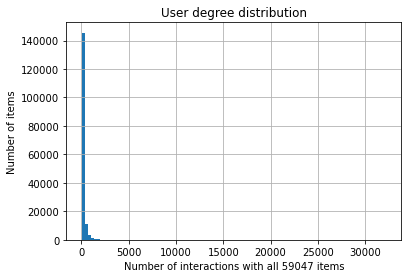

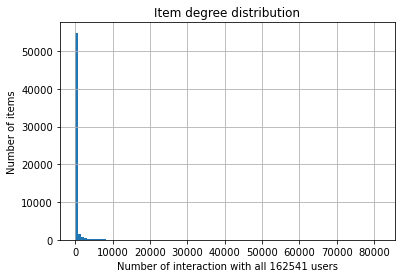

In [6]:
util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Filter items

In [7]:
def filter_items(utility_matrix, MIN_VOTES_PER_ITEM, HARD_LIMIT_ITEMS, seed): 
    # filter by item popularity
    if MIN_VOTES_PER_ITEM is not None:
        item_votes = utility_matrix.groupby('movieId')['rating'].count()
        print('Original items:', len(item_votes))
        item_votes = item_votes[item_votes >= MIN_VOTES_PER_ITEM]
        print(f'Keeping {len(item_votes)} items based on number of votes >= {MIN_VOTES_PER_ITEM}')
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(item_votes.index)]
        assert utility_matrix.groupby('movieId')['rating'].count().min() >= MIN_VOTES_PER_ITEM
        
    # randomly filter items to desired amount (!) Before we filter users as this also influences the latter
    if HARD_LIMIT_ITEMS is not None:
        items = pd.Series(utility_matrix['movieId'].unique()).sample(HARD_LIMIT_ITEMS, random_state=seed)
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(items)]
    
    print('Utility matrix:', utility_matrix.shape)
    return utility_matrix


def filter_users(utility_matrix, MIN_VOTES_PER_USER, MAX_VOTES_PER_USER, HARD_LIMIT_USERS, seed): 
    # filter by user voting
    if MIN_VOTES_PER_USER is not None:
        user_votes = utility_matrix.groupby('userId')['rating'].count()
        print('Original users:', len(user_votes))
        user_votes = user_votes[user_votes >= MIN_VOTES_PER_USER]  # at least these many votes on movies
        print(f'Keeping {len(user_votes)} users based on number of votes >= {MIN_VOTES_PER_USER}')
        utility_matrix = utility_matrix[utility_matrix.index.isin(user_votes.index)]
        assert utility_matrix.groupby('userId')['rating'].count().min() >= MIN_VOTES_PER_USER
        
    if MAX_VOTES_PER_USER is not None:
        user_votes = utility_matrix.groupby('userId')['rating'].count()
        print('Original users:', len(user_votes))
        user_votes = user_votes[user_votes <= MAX_VOTES_PER_USER]  # at least these many votes on movies
        print(f'Keeping {len(user_votes)} users based on number of votes <= {MAX_VOTES_PER_USER}')
        utility_matrix = utility_matrix[utility_matrix.index.isin(user_votes.index)]
        assert utility_matrix.groupby('userId')['rating'].count().max() <= MAX_VOTES_PER_USER
    
    # randomly filter users to desired amount
    if HARD_LIMIT_USERS is not None:
        users = utility_matrix.index.unique().to_series().sample(HARD_LIMIT_USERS, random_state=seed)
        utility_matrix = utility_matrix[utility_matrix.index.isin(users)]
    
    print('Utility matrix:', utility_matrix.shape)
    return utility_matrix

First, we filter the items. They will also be filtered down (unavoidable) later to exclude those we do not have features for.

Original items: 59047
Keeping 2613 items based on number of votes >= 1800
Utility matrix: (20557695, 3)
Number of users: 162535
Number of movies: 2613
Number of ratings: 20557695
Sparcity ratio: 4.8405% of utility matrix is known (non-blank).


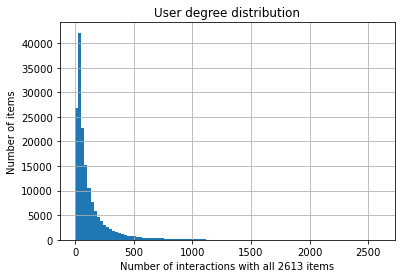

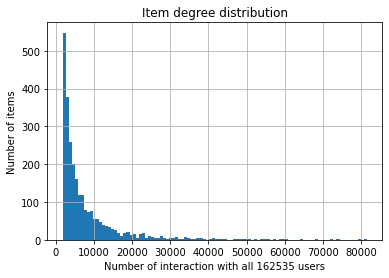

In [8]:
utility_matrix = filter_items(utility_matrix, MIN_VOTES_PER_ITEM, HARD_LIMIT_ITEMS, seed=seed)

util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Extract features for items

Load metadata from IMDB for however many movies you find.

In [9]:
def load_imdb_dfs(unique_movies: pd.Series, MIN_VOTES=100, MIN_YEAR=MIN_YEAR):
    # load each file with tconst (title id) as index
    print('Loading IMDB data...')
    tconst_files = [
        ('title.basics.tsv', None),
        ('title.ratings.tsv', None)
    ]
    all_dfs = []
    for file, usecols in tconst_files:
        df = pd.read_csv(imdb_path + file, index_col='tconst',  usecols=usecols,
                         sep='\t', encoding='utf-8',
                         keep_default_na=False, na_values=['\\N'])
        all_dfs.append(df)

    # combine all into one big fat DataFrame
    print('concatenating...')
    movies_df = pd.concat(all_dfs, axis=1)
    print('Reducing size to movies given...')
    movies_df = movies_df[(movies_df['titleType'].isin(['tvMovie', 'movie'])) &
                          (movies_df.index.isin(unique_movies.index))]
    print('done')

    # fix NA and types afterwards as it is not supported for read_csv
    movies_df['numVotes'] = movies_df['numVotes'].fillna(0).astype(np.uint16)
    movies_df['isAdult'] = movies_df['isAdult'].astype(bool)
    movies_df['startYear'] = movies_df['startYear'].fillna(0).astype(np.uint16)
    movies_df['endYear'] = movies_df['endYear'].fillna(0).astype(np.uint16)
    movies_df['genres'] = movies_df['genres'].fillna('').astype(str)

    # filtering
    movies_df = movies_df[(movies_df['numVotes'] >= MIN_VOTES) &
                          (movies_df['startYear'] >= MIN_YEAR) &
                          (~(movies_df['genres'].str.contains('Short', regex=False, na=False))) &
                          (movies_df['genres'].str != '')]

    print('Loading edges')
    principals_df = pd.read_csv(imdb_path + 'title.principals.tsv',
                                sep='\t',
                                encoding='utf-8',
                                keep_default_na=False,
                                na_values=['\\N'],
                                index_col='tconst',
                                usecols=['tconst', 'nconst', 'category'])
    principals_df = principals_df[principals_df.index.isin(movies_df.index)]
    principals_df = principals_df[principals_df['category'].isin(['actor', 'actress', 'writer', 'director', 'composer'])]

    # print(movies_df)
    # print(movies_df.shape)
    # print(principals_df)
    # print(principals_df.shape)

    return movies_df, principals_df


def load_imdb_metadata_features(unique_movies: pd.Series, MIN_APPEARANCES=MIN_APPEARANCES, save=True):
    movies_df, principals_df = load_imdb_dfs(unique_movies)
    
    # reduce unique_movies to the ones in movies_df TODO
    print(f'before: {len(unique_movies)}')
    print(unique_movies)
    unique_movies = unique_movies[(unique_movies.index.isin(movies_df.index)) & (unique_movies.index.isin(principals_df.index))]
    print(f'after: {len(unique_movies)}')
    
    assert len(unique_movies) > 0

    if save:
        movies_df.to_csv(movie_imdb_df_file + '.csv', columns=['genres'], mode='w')

    all_genres = [
        'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',  'Fantasy',
        'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',  'Thriller', 'War', 'Western', 'Biography', 'Music',
        'History', 'Family', 'Sport'
        # Rare (for now) categories: 'Film-Noir', 'Children'
    ]

    # Don't actually need to do this separately:
    # actors_mask = (principals_df['category'] == 'actor') | (principals_df['category'] == 'actress')
    # all_actors = sorted(list(principals_df['nconst'][actors_mask].unique()))
    #
    # directors_mask = principals_df['category'] == 'director'
    # all_directors = sorted(list(principals_df['nconst'][directors_mask].unique()))
    #
    # composer_mask = principals_df['category'] == 'composer'
    # all_composers = sorted(list(principals_df['nconst'][composer_mask].unique()))

    print('Number of personel:', len(principals_df), f'. Removing those with less than {MIN_APPEARANCES} appearances...')
    reduced_principals_df = principals_df.groupby('nconst').filter(lambda x: len(x) >= MIN_APPEARANCES)
    print(f'Left with {len(reduced_principals_df)}')

    all_personnel = sorted(list(reduced_principals_df['nconst'].unique()))

    F = len(all_genres) + len(all_personnel)
    features = np.zeros((len(unique_movies), F))
    for i, movieId in tqdm(enumerate(unique_movies.index), total=len(unique_movies)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # multi-hot encode genres
            genres = movies_df.loc[movieId]['genres'].split(',')
            genres = set([g.replace(' ', '') for g in genres])
            genres_feat = multi_hot_encode([genres], all_genres)
            # multi-hot encode personel
            personnel = set(principals_df.loc[movieId]['nconst'])
            personnel_feat = multi_hot_encode([personnel], all_personnel)
        
        # put together for features
        features[i, :len(all_genres)] = genres_feat
        features[i, len(all_genres):] = personnel_feat
    
    return pd.DataFrame(index=unique_movies.index, data=features), movies_df

In [10]:
if extract_features:
    # load audio features
    if use_audio:
        audio_features = pd.read_csv('../data/audio_features.csv', index_col='movieId', sep=';')
        # filter utility matrix to contain only movies for which we have audio
        utility_matrix = utility_matrix[utility_matrix['movieId'].isin(audio_features.index)]
        # utility_matrix = audio_features.join(utility_matrix, on='movieId', how='inner')
        print('Samples after keeping only audio movies:', utility_matrix.shape[0])
    
    # util_matrix_stats(utility_matrix)
    # assert len(utility_matrix) < 10000000, f"Utility matrix is going too be too big: {len(utility_matrix)}"
    
    # load movie features from only for movies in movieLens (for which we have ratings)
    if recalculate_metadata:
        print('Recalculating metadata...')
        unique_movies = pd.Series(index=utility_matrix['movieId'].unique().copy())
        imdb_metadata, movies_df = load_imdb_metadata_features(unique_movies)
        if use_genome_tags:
            genome_metadata = genome_metadata[genome_metadata.index.isin(unique_movies.index)]
            metadata = imdb_metadata.join(genome_metadata)
            metadata = metadata.fillna(0.0)   # shouldn't be any but just in case
        else:
            metadata = imdb_metadata
        
        # save metadata
        print(f'Found {metadata.shape[0]} movies.\nSaving metadata...')
        metadata.to_hdf(item_metadata_file + '.h5', key='metadata', mode='w')
        print('OK!')
    else:
        metadata = pd.read_hdf(item_metadata_file + '.h5', key='metadata')
        movies_df = None
    
    # Note: there can still be movies in ratings for which we have no features
    # so remove them like this:
    print('Removing movies for which we have no features...')
    utility_matrix = utility_matrix[utility_matrix['movieId'].isin(metadata.index)]
    
    # Note to check statistics: metadata.sum(axis=0)
    print("Metadata: ", metadata.shape)
    # print('Statistics:')
    # print(metadata.sum(axis=0))
    
    util_matrix_stats(utility_matrix)


Recalculating metadata...


C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\1827369287.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unique_movies = pd.Series(index=utility_matrix['movieId'].unique().copy())


Loading IMDB data...


C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\685920492.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(imdb_path + file, index_col='tconst',  usecols=usecols,


concatenating...
Reducing size to movies given...
done
Loading edges
before: 2613
tt0110912   NaN
tt0111495   NaN
tt0108394   NaN
tt0045152   NaN
tt0092890   NaN
             ..
tt0056217   NaN
tt1655442   NaN
tt0335119   NaN
tt0158811   NaN
tt0086034   NaN
Length: 2613, dtype: float64
after: 1610
Number of personel: 12186 . Removing those with less than 3 appearances...
Left with 7011


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1610/1610 [00:00<00:00, 2782.94it/s]
C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\1827369287.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  metadata.to_hdf(item_metadata_file + '.h5', key='metadata', mode='w')


Found 1610 movies.
Saving metadata...


C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\1827369287.py:27: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  metadata.to_hdf(item_metadata_file + '.h5', key='metadata', mode='w')


OK!
Removing movies for which we have no features...
Metadata:  (1610, 2380)
Number of users: 162344
Number of movies: 1610
Number of ratings: 12253856
Sparcity ratio: 4.6882% of utility matrix is known (non-blank).


### Filter users

Now, after being done with items, we filter the users so that they have the desired properties.

In [11]:
# filter again to make sure we get what we wanted
utility_matrix = filter_users(utility_matrix, MIN_VOTES_PER_USER, MAX_VOTES_PER_USER, HARD_LIMIT_USERS, seed=seed)

Original users: 162344
Keeping 34389 users based on number of votes >= 100
Original users: 34389
Keeping 30470 users based on number of votes <= 400
Utility matrix: (928864, 3)


Number of users: 5000
Number of movies: 1610
Number of ratings: 928864
Sparcity ratio: 11.5387% of utility matrix is known (non-blank).


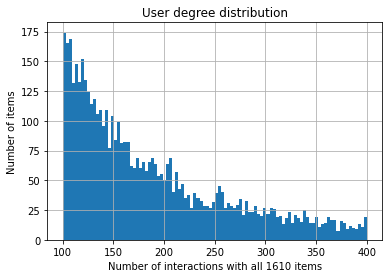

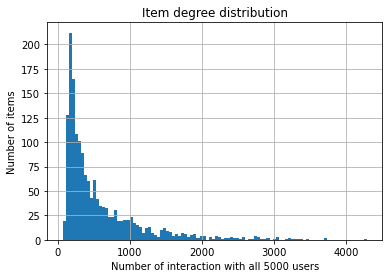

In [12]:
util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

Filter items again to ensure FINAL_MIN_VOTES_PER_ITEM.

In [13]:
utility_matrix = filter_items(utility_matrix, FINAL_MIN_VOTES_PER_ITEM, HARD_LIMIT_ITEMS, seed=seed)

Original items: 1610
Keeping 1466 items based on number of votes >= 150
Utility matrix: (910281, 3)


Number of users: 5000
Number of movies: 1466
Number of ratings: 910281
Sparcity ratio: 12.4186% of utility matrix is known (non-blank).


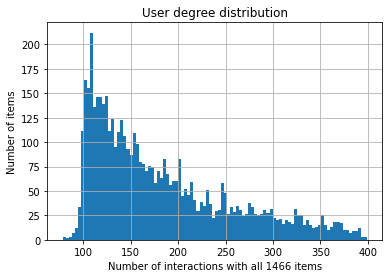

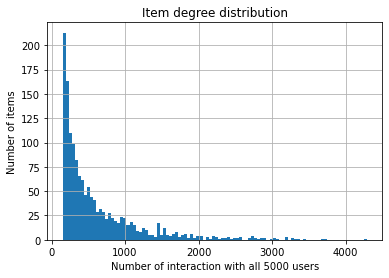

In [14]:
util_matrix_stats(utility_matrix)
explore_utility_matrix(utility_matrix)

### Examine item metadata

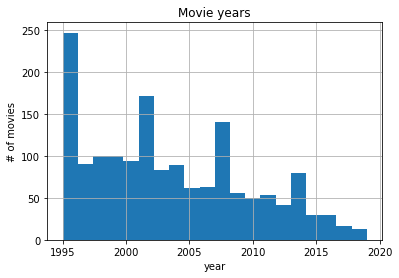

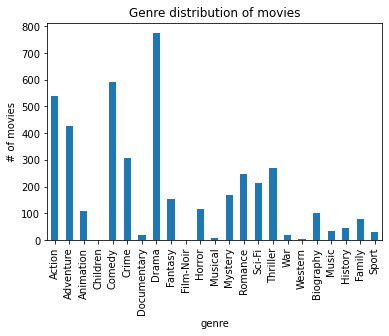

In [15]:
def examine_items(movies_df):
    # years
    plt.title("Movie years")
    plt.xlabel("year")
    plt.ylabel("# of movies")
    movies_df['startYear'].hist(bins=20)
    plt.show()
    
    # genres
    all_genres = [
        'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',  'Fantasy',
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',  'Thriller', 'War', 'Western', 'Biography', 'Music',
        'History', 'Family', 'Sport'
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m = movies_df['genres'].apply(lambda x: multi_hot_encode([x.split(',')], all_genres)[0])
    m = pd.DataFrame(m.to_list(), columns=all_genres)
    
    plt.title("Genre distribution of movies")
    plt.xlabel("genre")
    plt.ylabel("# of movies")
    m.sum(axis=0).plot.bar()
    plt.show()
    
    # TODO: others?
    

if extract_features and movies_df is not None:
    examine_items(movies_df)

## Train-val-test split

There are many ways to perform train-val-test split depending on which generalization ability we are interested in measuring (i.e. depending on our task) (training is not affected). 

In [16]:
def train_val_test_split_flat(utility_matrix, val_size, test_size, seed):
    """ Random split on all interactions of the utility matrix
        Doesn't measure generalization to new users or items, only to unknown interactions between known user/items as in pure CF
    """
    
    # set random seed for reproducability
    np.random.seed(seed)

    # determine splits in a shuffled order of all samples like so:
    # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
    size = len(utility_matrix)
    val_split = int(np.floor(val_size * size))
    test_split = val_split + int(np.floor(test_size * size))

    # randomly shuffly the indexes of all data
    indices = list(range(size))
    np.random.shuffle(indices)

    # apply splits to get mutually exclusive subsets of the original data
    val = utility_matrix.iloc[indices[:val_split]]
    test = utility_matrix.iloc[indices[val_split: test_split]]
    train = utility_matrix.iloc[indices[test_split:]]
    
    return train, val, test


def train_val_test_split_leave_percentage(utility_matrix, val_size, test_size, seed):
    """ Randomly select val_num, test_num interactions per user to hold out for val and test sets.
        Equally represents each user in the val/test sets despite how many interaction he has overall.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    train, val, test = [], [], []
    for u in tqdm(users, total=len(users)):
        user_interactions = utility_matrix.loc[u]
        
        # determine splits in a shuffled order of all samples like so:
        # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
        size = len(user_interactions)
        val_split = max(int(np.floor(val_size * size)), 2)
        test_split = val_split + max(int(np.floor(test_size * size)), 2)

        # randomly shuffly the indexes of all users
        indices = list(range(size))
        np.random.shuffle(indices)
        
        # apply splits
        val.append(user_interactions[:val_split])
        test.append(user_interactions[val_split: test_split])
        train.append(user_interactions[test_split:])
    
    train = pd.concat(train)
    val = pd.concat(val)
    test = pd.concat(test)
    
    return train, val, test




def train_val_test_split_leave_k(utility_matrix, val_num, test_num, seed):
    """ Randomly select val_num, test_num interactions per user to hold out for val and test sets.
        Equally represents each user in the val/test sets despite how many interaction he has overall.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    train, val, test = [], [], []
    for u in tqdm(users, total=len(users)):
        user_interactions = utility_matrix.loc[u]
        
        # determine splits in a shuffled order of all samples like so:
        # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
        assert val_num + test_num < len(user_interactions) / 2, "Choose lower val and test nums"
        val_split = val_num
        test_split = val_num + test_num

        # randomly shuffly the indexes of all users
        size = len(user_interactions)
        indices = list(range(size))
        np.random.shuffle(indices)
        
        # apply splits
        val.append(user_interactions[:val_split])
        test.append(user_interactions[val_split: test_split])
        train.append(user_interactions[test_split:])
    
    train = pd.concat(train)
    val = pd.concat(val)
    test = pd.concat(test)
    
    return train, val, test


def train_val_test_split_on_users(utility_matrix, val_size, test_size, seed):
    """ Random split on users of the utility matrix. All interactions associated with a user go with him on the same set. 
        Measures generalization to new users but considers items fixed.
    """
    
    # set random seed for reproducability
    np.random.seed(seed)
    
    # get users from matrix
    users = utility_matrix.index.unique().to_series()

    # determine splits in a shuffled order of all samples like so:
    # | <-- val set --> | <-- test set --> | <--------- train set ---------> |
    size = len(users)
    val_split = int(np.floor(val_size * size))
    test_split = val_split + int(np.floor(test_size * size))

    # randomly shuffly the indexes of all users
    indices = list(range(size))
    np.random.shuffle(indices)
    
    # apply splits to users and from them get mutually exclusive subsets of the original data
    val = utility_matrix.loc[users.iloc[indices[:val_split]]]
    test = utility_matrix.loc[users.iloc[indices[val_split: test_split]]]
    train = utility_matrix.loc[users.iloc[indices[test_split:]]]
    
    return train, val, test

In [17]:
# TODO: Which of the two splitting methods?
# train, val, test = train_val_test_split_leave_k(utility_matrix, val_num=5, test_num=5, seed=seed)
train, val, test = train_val_test_split_leave_percentage(utility_matrix, val_size, test_size, seed)
# train, val, test = train_val_test_split_flat(utility_matrix, val_size, test_size, seed)
train.shape[0], val.shape[0], test.shape[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6687.37it/s]


(732697, 88792, 88792)

In [18]:
# train.shape[0], val.shape[0], test.shape[0]

Save sets.

In [19]:
def save_set(matrix: pd.DataFrame, name: str):
    matrix.to_csv(name + '.csv', columns=['movieId', 'rating'], mode='w')

save_set(train, train_set_file)
save_set(val, val_set_file)
save_set(test, test_set_file)
save_set(utility_matrix, full_matrix_file)

Exploration of sets. Remember that, if we are flat splitting, each user will potentially have interactions randomly distributed across all sets.

Number of users: 5000
Number of movies: 1447
Number of ratings: 732697
Sparcity ratio: 10.1271% of utility matrix is known (non-blank).


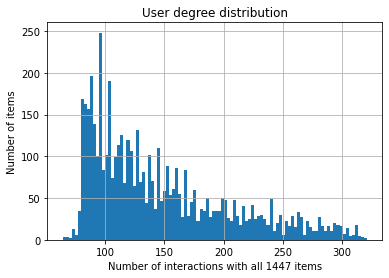

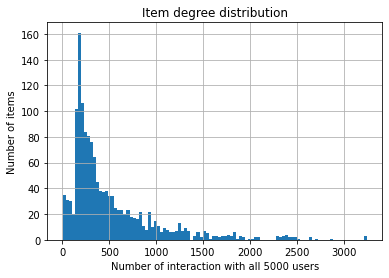

In [20]:
util_matrix_stats(train)
explore_utility_matrix(train)

Number of users: 5000
Number of movies: 705
Number of ratings: 88792
Sparcity ratio: 2.5189% of utility matrix is known (non-blank).


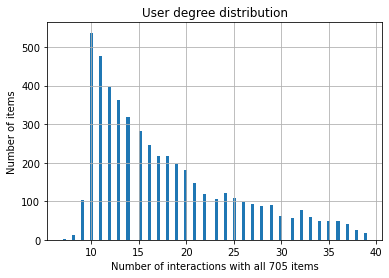

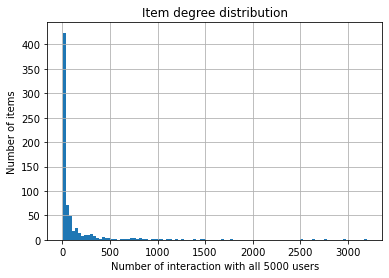

In [21]:
util_matrix_stats(val)
explore_utility_matrix(val)

Number of users: 5000
Number of movies: 957
Number of ratings: 88792
Sparcity ratio: 1.8556% of utility matrix is known (non-blank).


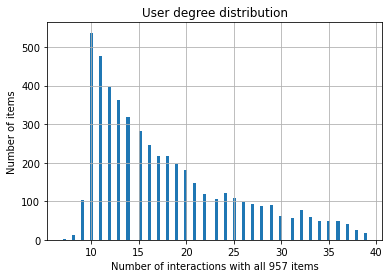

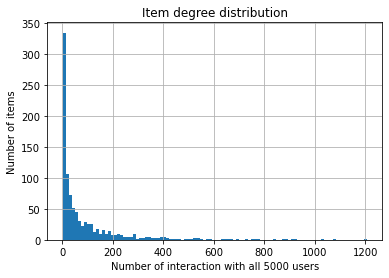

In [22]:
util_matrix_stats(test)
explore_utility_matrix(test)

## Extract user ratings and fixed user embeddings from features

(5000, 4)
User ratings:
                                                    rating  \
userId                                                      
61      [3.0, 4.0, 4.0, 2.0, 4.0, 2.0, 4.0, 3.0, 4.0, ...   
62      [4.5, 4.5, 4.0, 4.5, 4.5, 4.5, 4.5, 4.0, 4.0, ...   
125     [3.0, 5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, ...   
164     [4.0, 4.5, 4.0, 4.5, 4.0, 3.5, 4.0, 4.5, 4.5, ...   
175     [2.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, ...   
...                                                   ...   
162428  [4.5, 5.0, 3.5, 4.5, 3.0, 5.0, 4.0, 4.0, 2.0, ...   
162457  [4.0, 4.0, 4.0, 3.5, 3.5, 3.5, 2.5, 4.0, 3.5, ...   
162479  [4.0, 3.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, ...   
162498  [1.0, 1.5, 4.5, 3.0, 4.0, 4.5, 3.0, 1.0, 4.0, ...   
162519  [3.0, 2.0, 3.0, 4.0, 4.0, 2.0, 2.0, 3.0, 4.0, ...   

                                                  movieId  meanRating  \
userId                                                                  
61      [tt0115433, tt0116250, tt01

C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\2222676388.py:24: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['rating', 'movieId'], dtype='object')]

  user_ratings.to_hdf(user_ratings_file + '.h5', key='user_ratings', mode='w')


OK!


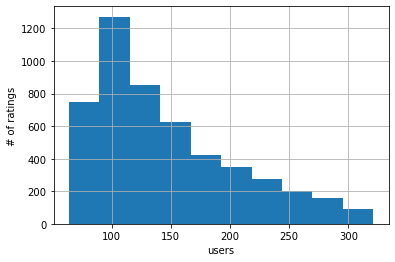

Creating user embeddings...


Creating user embeddings...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 298.70it/s]


Saving...
Done


In [23]:
def create_user_embedding(user_ratings: pd.DataFrame, metadata: pd.DataFrame):
    avg_rating = (user_ratings['rating'].mean() + 2.5) / 2      # TODO: move average towards neutral 2.5?
    return ((user_ratings['rating'] - avg_rating).reshape(-1, 1) * metadata.loc[user_ratings['movieId']].values).mean(axis=0)


if save_user_ratings:
    
    # TODO: Which should I use? Train would be an obvious choice but what if we re splitting on users
    ratings_to_use = train
    
    
    # IMPORTANT to sort by movieId
    user_ratings: pd.DataFrame = ratings_to_use.drop('timestamp', axis=1).sort_values(by='movieId').groupby(
        'userId').agg({'rating': list, 'movieId': list})
    user_ratings['rating'] = user_ratings['rating'].apply(lambda x: np.array(x))
    user_ratings['movieId'] = user_ratings['movieId'].apply(lambda x: np.array(x))
    user_ratings['meanRating'] = user_ratings['rating'].apply(lambda x: np.mean(x))
    user_ratings['numRatings'] = user_ratings['rating'].apply(lambda x: len(x))
    
    print(user_ratings.shape)
    print('User ratings:\n', user_ratings)

    print('Saving user ratings from train set only...')
    user_ratings.to_hdf(user_ratings_file + '.h5', key='user_ratings', mode='w')
    print('OK!')
    
    # print(f'Average number of ratings per user (in train set): {user_ratings["rating"].apply(lambda x: len(x)).mean()}')
    plt.ylabel("# of ratings")
    plt.xlabel("users")
    user_ratings["rating"].apply(lambda x: len(x)).hist()
    plt.show()
    
    if extract_features and create_user_embeddings_too:
        # create user_embeddings from user ratings once beforehand
        # Note: This takes a very long time
        print('Creating user embeddings...')
        user_embeddings = pd.DataFrame(index=user_ratings.index.unique().copy(), data=np.zeros((len(user_ratings.index.unique()), metadata.shape[1])))
        for userId, user_ratings in tqdm(user_ratings.groupby('userId'), desc='Creating user embeddings...'):
            # Note: iloc[0] is needed because of some weird encapsulation idk
            user_embeddings.at[userId, :] = create_user_embedding(user_ratings.iloc[0], metadata)
        
        print('Saving...')
        user_embeddings.to_hdf(user_embeddings_file + '.h5', key='user_embeddings', mode='w')
        print('Done')

## Create ranking dataset

To create a corresponding dataset with $(user, item, item)$ triplets $(u, i, j)$ where $i$ should be ranked higher than $j$ for user $u$ we collect all possible negatives $j$ options for each $(u, i)$ user - positive item pair. During training we will sample one negative from all the options gathered here based on some formula.

In [24]:
np.random.seed(seed)         # set seed (once) for reproducible results


def save_ranking_set(matrix: pd.DataFrame, name: str):
    matrix.to_hdf(name + '.h5', mode='w', index=False, key=name)


# create triplets only for train set (val ndcg as val loss, test loss is pointless)
samples = train
frac = None  #  Use None so as to keep all options
# min and max negative samples per positive sample TODO: WRONG, it is sampling entire rating categories instead of negatives...
min_samples = 1
max_samples = 20

options = []
triplets = []
per_user = samples.groupby(['userId', 'rating']).agg(list) 
for (userId, rating), row in tqdm(per_user.iterrows(), total=per_user.shape[0]):
    other_user_ratings = per_user.loc[userId, :]
    other_user_ratings = other_user_ratings[other_user_ratings.index < rating]

    if other_user_ratings.shape[0] == 0:      # nothing to pair
        continue        

    # for each positive sample
    for movie1 in row['movieId']:
        # sample through all possible negatives (potentially different sample for each positive)
        if frac is not None:
            pool = other_user_ratings.sample(n=min(max_samples, max(min_samples, round(frac * other_user_ratings.shape[0]))),
                                             weights=other_user_ratings.index)   # give somewhat higher weight to higher ratings
            options.append(pool.shape[0])
        else:
            pool = other_user_ratings

        # gather possible negatives
        negatives = []
        ratings = []
        for rating2, row2 in pool.iterrows():
            if rating > rating2:              # probably redundant but just in case
                for movie2 in row2['movieId']:
                    negatives.append(movie2)
                    ratings.append(rating2)

        if len(negatives) > 0:
            triplets.append((userId, movie1, negatives, ratings))

triplet_df = pd.DataFrame(triplets, columns=['userId', 'positive_movieId', 'negative_movieIds', 'negative_ratings'])
print('Saving set...')
save_ranking_set(triplet_df, f'../data/ranking_train')   # TODO: hardcoded path should be in globals?
print('Ok!')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39742/39742 [01:33<00:00, 426.88it/s]
C:\Users\mikem\miniconda3\envs\dl\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '..'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\mikem\AppData\Local\Temp\ipykernel_4484\1227248424.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['positive_movieId', 'negative_movieIds', 'negative_ratings'], dtype='object')]

  matrix.to_hdf(name + '.h5', mode='w', index=False, key=name)


Saving set...
Ok!


In [25]:
triplet_df

,userId,positive_movieId,negative_movieIds,negative_ratings
0,61,tt0116996,"[tt0134084, tt0184858]","[1.0, 1.0]"
1,61,tt0117571,"[tt0134084, tt0184858]","[1.0, 1.0]"
2,61,tt0120053,"[tt0134084, tt0184858]","[1.0, 1.0]"
3,61,tt0120082,"[tt0134084, tt0184858]","[1.0, 1.0]"
4,61,tt0120885,"[tt0134084, tt0184858]","[1.0, 1.0]"
...,...,...,...,...
707180,162519,tt0227538,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707181,162519,tt0245712,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707182,162519,tt0203119,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707183,162519,tt0133152,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."


In [26]:
df = pd.read_hdf('../data/ranking_train.h5')
df

,userId,positive_movieId,negative_movieIds,negative_ratings
0,61,tt0116996,"[tt0134084, tt0184858]","[1.0, 1.0]"
1,61,tt0117571,"[tt0134084, tt0184858]","[1.0, 1.0]"
2,61,tt0120053,"[tt0134084, tt0184858]","[1.0, 1.0]"
3,61,tt0120082,"[tt0134084, tt0184858]","[1.0, 1.0]"
4,61,tt0120885,"[tt0134084, tt0184858]","[1.0, 1.0]"
...,...,...,...,...
707180,162519,tt0227538,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707181,162519,tt0245712,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707182,162519,tt0203119,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
707183,162519,tt0133152,"[tt0119137, tt0133952, tt0177789, tt0183523, t...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."


Check how many negatives per positive

<AxesSubplot:>

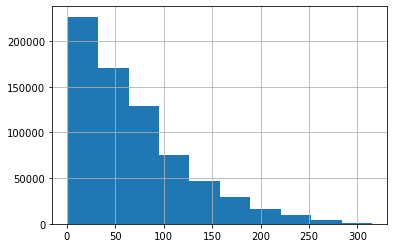

In [27]:
df['negative_ratings'].apply(lambda x: len(x)).hist()

In [28]:
# pd.Series(options).hist(bins=20)

In [29]:
# list(movies_df['primaryTitle'].values)